# No show appointment dataset

The dataset is from [Kaggle](https://www.kaggle.com/joniarroba/noshowappointments/home).

It is the records of doctors appointments including the no show from Brazil.

The datasets include 110k lines, with no missing data. There are two identifications : PatientId and AppointmentID.

There are 62299 PatientID and 110527 AppointmentID.

Most features are self explanatory, but :
- ScheduledDay : It is the timestamp when the appointment was recorded.
- AppointmentDay : It is the day of the appointment, without time.
- Neighbourhood : This is the Neightbourhood where the appointment will take place.
- SMS_received : 1 or more messages sent to the patient.

Noted in the dataset description, the Neighbourhood of the visit is not always linked to where the people can from, as "Vitória is a capital city and received dozens of patients from other cities."

For readability, I will just change a couple of column names to correct for typo and remove hyphen.

Index:
- [Missing values and duplicates study](#missing)

- [Droping the duplicates](#drop)

- [Correlations between the features and the label](#correlations)

- [Effect delay and age on the no-show rate](#no_show)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

import os
import pandas as pd

from matplotlib.ticker import PercentFormatter

import seaborn as sns
from scipy.stats import ttest_ind
from itertools import combinations
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 22})


In [2]:
with open("KaggleV2-May-2016.csv", 'rt') as f:
    original = pd.read_csv(f)

In [3]:
original.columns = ['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received', 'No_show']

In [4]:
for col in ['ScheduledDay','AppointmentDay']:
    original[col] = pd.to_datetime(original[col])
    

In [5]:
original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null datetime64[ns]
AppointmentDay    110527 non-null datetime64[ns]
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hypertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handicap          110527 non-null int64
SMS_received      110527 non-null int64
No_show           110527 non-null object
dtypes: datetime64[ns](2), float64(1), int64(8), object(3)
memory usage: 11.8+ MB


# Missing values
<a id="missing"></a>
There are no missing values.

# Duplicates
Looking at duplicates, if you ignore the ID numbers, there are around 1293 duplicates, meaning 1% of the records, which is negligeable.

Given we only have the date of the appointment (and not the time), this could mean someone could have booked many different appointment the same day? Or this could also be a system problem.

As the ScheduleDay is a timestamp precise to the second, it can be used as a proxy for transaction ID.

Looking at duplicate, it seems that for comparable line, we can have different SMS_received and No Show status, which seems to imply that for the same person having multiple appointment the same day might come to one and not to the other. This goes in favor of the system creating 2 appoitments at the time of the Scheduling (they have the same timestamp to the seconds).

As the number of duplicates is low, we will just check if they are not from particular Age group of a particular Neighbourhood.

## Duplicates in Neighbourhood

The neighbourhood with the most duplicates is ANDORINHAS, with 10% of duplicates lines, there are duplcate line in almost all neighbourhoods.

## Duplicates and Age group

There are potential duplicates in all age group. The exact distribution is different from the distribution of the original dataset, but here we are speaking of very small numbers.

## Duplicates and ScheduleDate

Looking at the distribution of the week number for the duplicates, there is no particular moment for those duplicates.

To move forward, [we will drop the duplicates](#drop), taking into acount lines that requires input (No Show and SMS-Received).





In [8]:
find_dup = original\
    .groupby(['Gender', 'ScheduledDay','AppointmentDay', 'Age', 
              'Neighbourhood', 'Scholarship', 'Hypertension','Diabetes', 
              'Alcoholism', 'Handicap'])["AppointmentID"].count()

# Number of potential duplicates per neighbourhood (top 5)

In [10]:
compare_dup = pd.concat([original.Neighbourhood.value_counts(), 
            find_dup[find_dup>1].reset_index().Neighbourhood.value_counts()],sort=False, axis=1).fillna(0)
compare_dup.columns = ['origin', 'potential_duplicates']
compare_dup["percent"] = (compare_dup.potential_duplicates*2)/compare_dup.origin
compare_dup.sort_values(["percent"],ascending=False).head()

,origin,potential_duplicates,percent
ANDORINHAS,2262,124.0,0.109637
PIEDADE,452,16.0,0.070796
ITARARÉ,3514,105.0,0.059761
COMDUSA,310,9.0,0.058065
RESISTÊNCIA,4431,122.0,0.055067


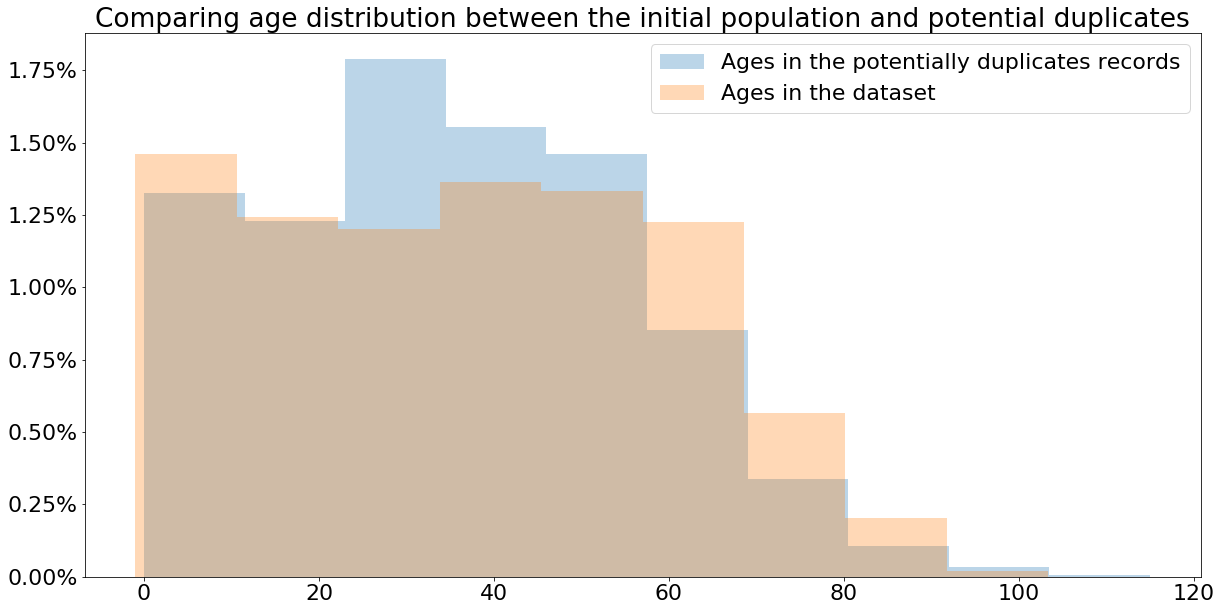

In [14]:
plt.hist(find_dup[find_dup>1].reset_index().Age,alpha=0.3,density=True,label="Ages in the potentially duplicates records")
plt.hist(original.Age,alpha=0.3,density=True,label="Ages in the dataset")
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.title("Comparing age distribution between the initial population and potential duplicates");



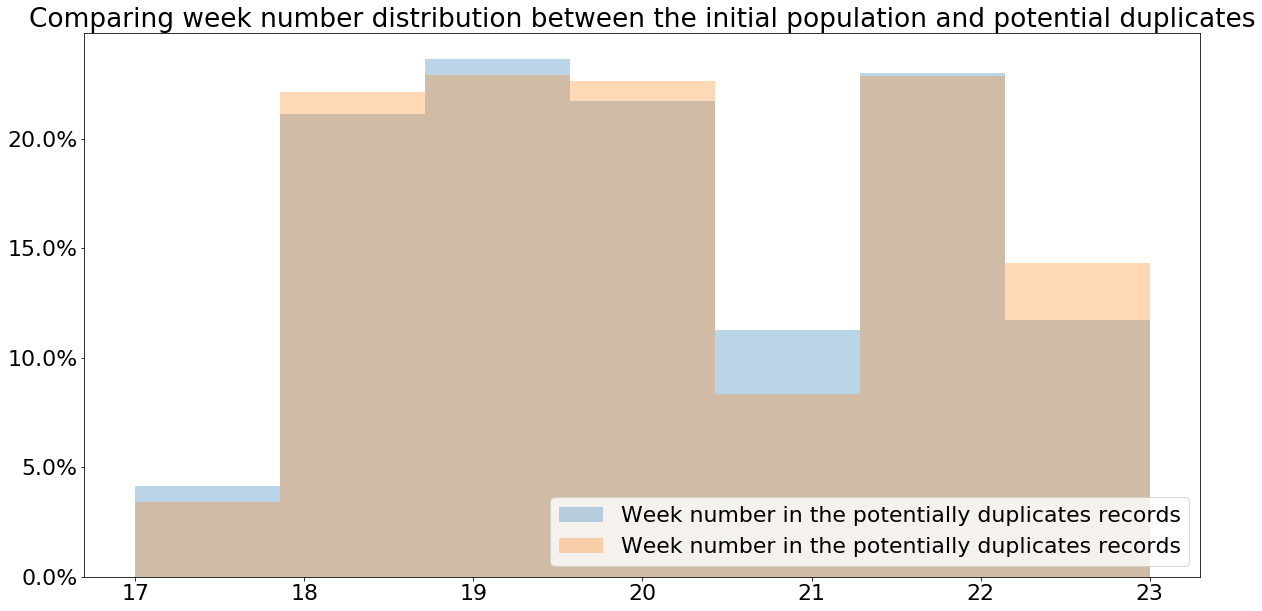

In [17]:
_,bins,_ = plt.hist(find_dup[find_dup>1].reset_index().AppointmentDay.dt.week,alpha=0.3,density=True,bins=7,label="Week number in the potentially duplicates records")
plt.hist(original.AppointmentDay.dt.week,alpha=0.3,bins=bins,density=True,label="Week number in the potentially duplicates records")
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.legend(loc=4);
plt.title("Comparing week number distribution between the initial population and potential duplicates");




<a id="drop" name="drop"></a>
# Getting the data ready.
## Drop the duplicates
We will drop the duplicates, keeping line mentionning SMS action and the patient showing up (i.e. No_Show False), this results in droping only 1354 lines.

## Variable format
We will also transform the "No-show" variable make it easier to create the graphs.
For the numerical variable like **Age**, we will create categories to make the graphs easier to read.

## Delay

The appointment can be scheduled a long time before the actual day for the appointment. A feature **delay** represent the delay in days between the day the appointment was scheduled and the appointment. Appointment scheduled the same day will have a delay of 0.

We can see that a majority of the appointments are (# 40 0000 out of 100 0000) are schedue the same day.


## Number of appointments

As some patients have many appointments, we can also look at if the number of appointments the people have has an indicators of the percentage of No-show, the hypothesis being that someone that often goes to the doctor will have a better chance of remembering an appointment.

We will define 2 variables, **previous** that take into account the number of appointment someone has taken before the appointment, and **appoint_nb** that is the total number of appointments each PatientId has taken.

[Next](#correlations)

In [18]:
dataset_for_review = original.sort_values(["SMS_received","No_show"],ascending=[False,True])\
        .drop_duplicates(['Gender', 'ScheduledDay','AppointmentDay', 'Age', 
              'Neighbourhood', 'Scholarship', 'Hypertension','Diabetes', 
              'Alcoholism', 'Handicap'],keep="first")

In [19]:
original.shape[0]-dataset_for_review.shape[0]

1354

# Feature engineering previous

This feature is actual long to generate, it looks at the number of appointments you had before this one, but as the dataset we have is only a snapshot of the complete dataset, this might not be represensative.

This feature will not be used.

In [13]:
dataset_for_review["previous"] = dataset_for_review.apply(lambda x: sum((dataset_for_review.PatientId==x["PatientId"])&(dataset_for_review.AppointmentDay<x.AppointmentDay))
                        ,axis=1)

In [14]:
dataset_for_review["previous_cat"] = pd.cut(dataset_for_review.previous,[-1,0.99,2,6,100])

# Feature engineering: appoint_nb

This features is much faster to calculate, you calculate the total number of appointments, including future appointments.

This might sounds like a not realistic approach, but as we have only a snapshot, this is not too much of a stretch.

Also it helps generate more case of high number of appointments, in previous case, very few cases were generated.

In [20]:
appoint_nb_info = dataset_for_review.groupby("PatientId").AppointmentID.count()\
    .reset_index().rename({"AppointmentID":"appoint_nb"},axis=1)
dataset_for_review = dataset_for_review.merge(appoint_nb_info,on="PatientId")
dataset_for_review["appoint_nb_cat"] = pd.cut(dataset_for_review.appoint_nb,[-1,5,88])

In [21]:
np.max(dataset_for_review.appoint_nb)

88

# Feature enginering : delay

We want to capture the number of days between the moment the appointment was scheduled and the appointment.

As this is a long tailed distribution, we will generate categories of roughly the same population.

In [22]:
dataset_for_review["delay"] = dataset_for_review.AppointmentDay.dt.date - dataset_for_review.ScheduledDay.dt.date
dataset_for_review.delay= dataset_for_review.delay.dt.days
dataset_for_review.loc[dataset_for_review.delay<0,"delay"]= 0# There are a few negative delays
min_cut, max_cut =  dataset_for_review.delay.min(), dataset_for_review.delay.max()
dataset_for_review["lag_cat"] = pd.cut(dataset_for_review.delay,
                                        [-1,0.1,2,10,20,30,max_cut])
lag_cat_labels = ["Same Day"
                  ,"≤ 2 days"
                  ,"≤ 10 days"
                  ,"≤ 20 days"
                 ,"≤ 30 days"
                 ,"> 30 days"]

In [23]:
dataset_for_review["lag_cat"].unique()
dataset_for_review["week"]=dataset_for_review.AppointmentDay.dt.week

In [24]:
#dataset_for_review["No_show"] = pd.Categorical(dataset_for_review["No_show"])
dfDummies = pd.get_dummies(dataset_for_review["No_show"], prefix = "no_show",drop_first=True)
data_all_num = pd.concat([dataset_for_review,dfDummies], axis=1)

# Age categories

As we also have a long tailed distribution of the ages, we will generated 2 categoricals variables for Age :
- One with 5 groups
- A second one with 10 groups if we need to look at more details.

Each category have an similar size.

In [26]:
data_all_num["age_cat_5_groups"] = pd.cut(data_all_num.Age,[-1.001,11,27,42,53,115])
age_5_groups_labels = ['Age≤ 11','11<Age≤27','27<Age≤42','42<Age≤53','53<Age']
print(data_all_num["age_cat_5_groups"].unique(),age_5_groups_labels)
data_all_num["age_cat"] = pd.qcut(data_all_num.Age,10)
print(data_all_num["age_cat"].unique())
age_cat_labels = ['Age≤ 5','5<Age≤13','13<Age≤21','21<Age≤30','30<Age≤37'
                  ,'37<Age≤45','45<Age≤52','52<Age≤59','59<Age≤68','68<Age']


[(11.0, 27.0], (27.0, 42.0], (42.0, 53.0], (53.0, 115.0], (-1.001, 11.0]]
Categories (5, interval[float64]): [(-1.001, 11.0] < (11.0, 27.0] < (27.0, 42.0] < (42.0, 53.0] < (53.0, 115.0]] ['Age≤ 11', '11<Age≤27', '27<Age≤42', '42<Age≤53', '53<Age']
[(13.0, 21.0], (21.0, 30.0], (45.0, 52.0], (37.0, 45.0], (68.0, 115.0], (52.0, 59.0], (-1.001, 5.0], (59.0, 68.0], (5.0, 13.0], (30.0, 37.0]]
Categories (10, interval[float64]): [(-1.001, 5.0] < (5.0, 13.0] < (13.0, 21.0] < (21.0, 30.0] ... (45.0, 52.0] < (52.0, 59.0] < (59.0, 68.0] < (68.0, 115.0]]


# Checking the grouping does not generate uneven size per feature

In [28]:
data_all_num.groupby("age_cat_5_groups").count()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,...,Handicap,SMS_received,No_show,appoint_nb,appoint_nb_cat,delay,lag_cat,week,no_show_Yes,age_cat
age_cat_5_groups,,,,,,,,,,,,,,,,,,,,,
"(-1.001, 11.0]",19748,19748,19748,19748,19748,19748,19748,19748,19748,19748,...,19748,19748,19748,19748,19748,19748,19748,19748,19748,19748
"(11.0, 27.0]",21037,21037,21037,21037,21037,21037,21037,21037,21037,21037,...,21037,21037,21037,21037,21037,21037,21037,21037,21037,21037
"(27.0, 42.0]",21689,21689,21689,21689,21689,21689,21689,21689,21689,21689,...,21689,21689,21689,21689,21689,21689,21689,21689,21689,21689
"(42.0, 53.0]",16538,16538,16538,16538,16538,16538,16538,16538,16538,16538,...,16538,16538,16538,16538,16538,16538,16538,16538,16538,16538
"(53.0, 115.0]",30161,30161,30161,30161,30161,30161,30161,30161,30161,30161,...,30161,30161,30161,30161,30161,30161,30161,30161,30161,30161


(0, 175)

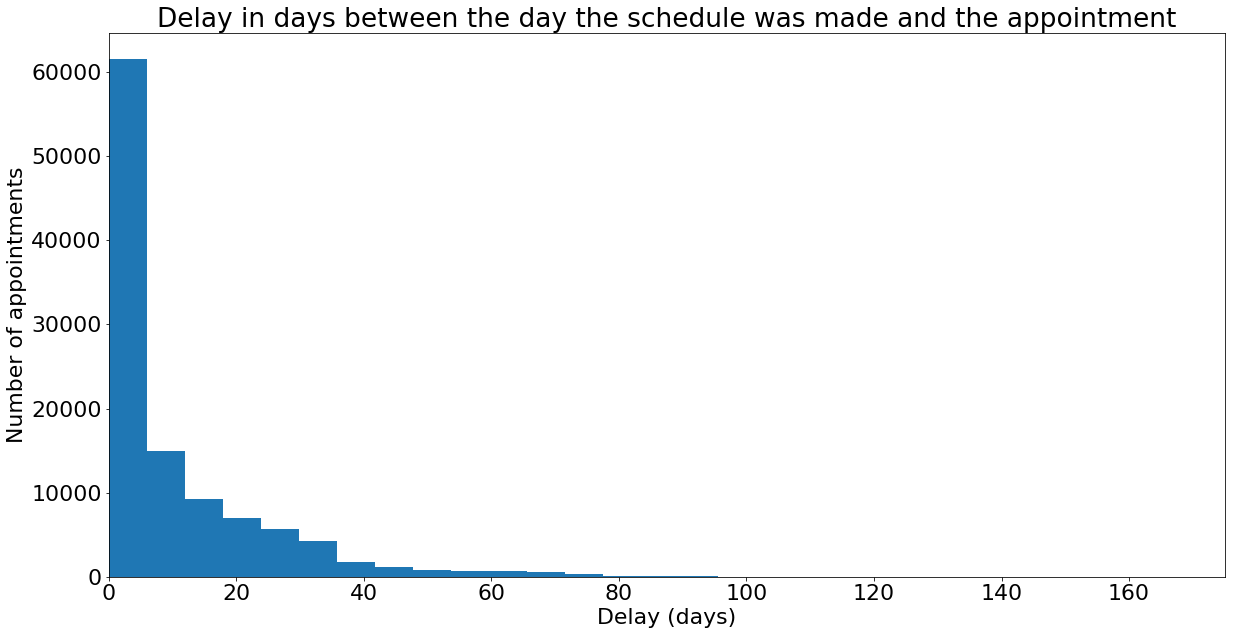

In [29]:
plt.hist(dataset_for_review["delay"],30);
plt.title("Delay in days between the day the schedule was made and the appointment");
plt.xlabel("Delay (days)");
plt.ylabel("Number of appointments");
plt.xlim(0,175)

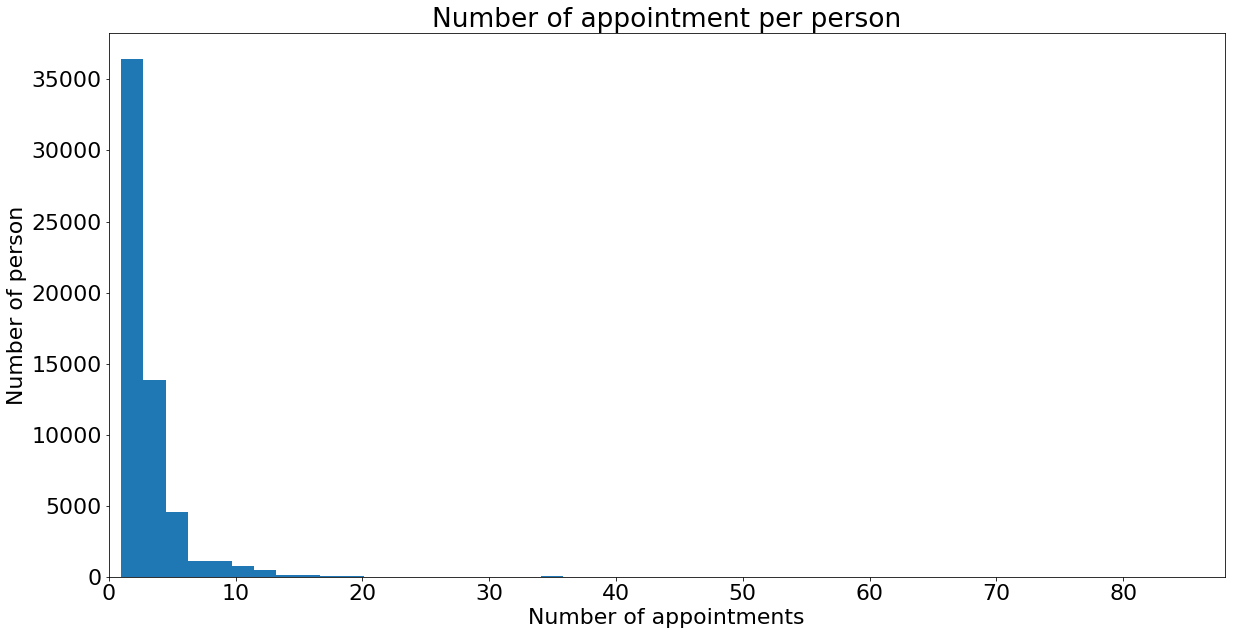

In [31]:
plt.hist(dataset_for_review[dataset_for_review.delay>2]["appoint_nb"],50);
plt.title("Number of appointment per person");
plt.xlabel("Number of appointments");
plt.ylabel("Number of person");
plt.xlim(0,88);

# Correlations
<a id="correlations"></a>
We can notice there are strong correlations between conditions like Hypertension, Diabetes and  Alcolism with Age.

Looking are the features that are correlated with the No-Show, **delay** is the variable that has the biggest correlation with **No-show** where **Age** is the one with the biggest negative correlation.

[Next](#no_show)

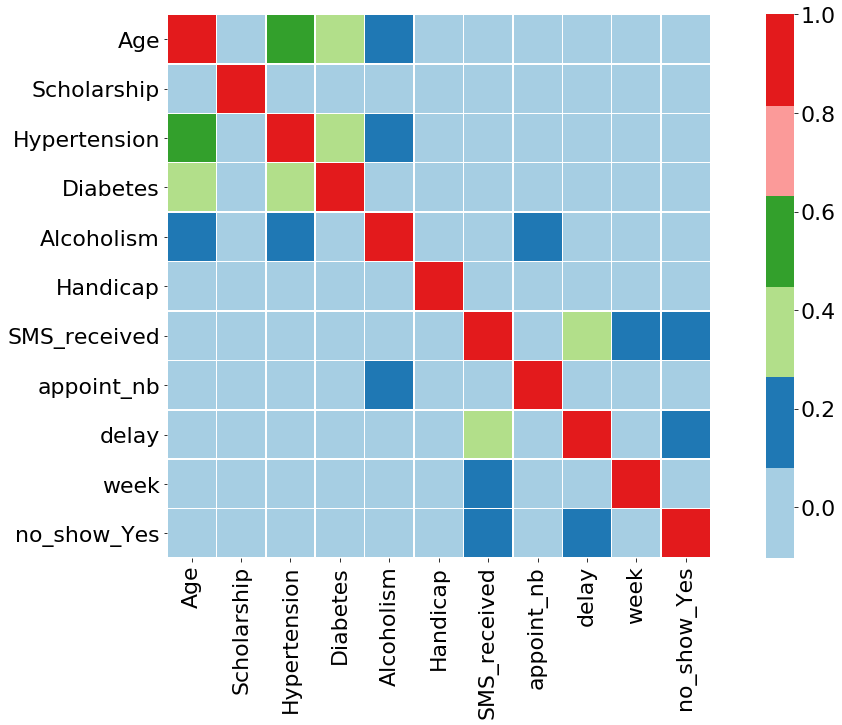

In [32]:
colors = sns.color_palette("Paired",6)
ax = sns.heatmap(data_all_num.drop(["PatientId","AppointmentID"]
                ,axis=1).corr()
                ,cmap=colors
                ,linewidths=.5
                ,square= True)

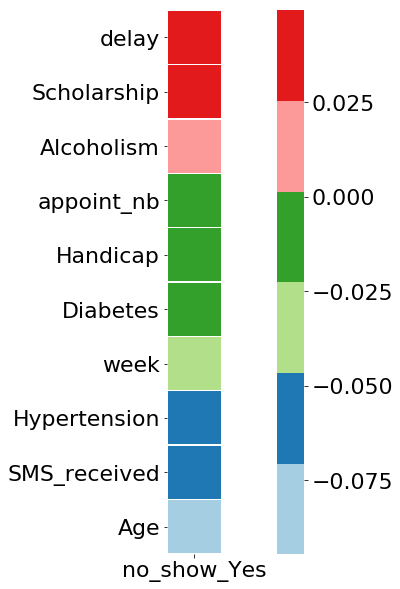

In [34]:
correlations= data_all_num[(data_all_num.delay>5)&(data_all_num.delay<40)]\
                .drop(["PatientId","AppointmentID"],axis=1).corr()\
                [["no_show_Yes"]]
sns.heatmap(correlations[correlations.index!="no_show_Yes"]\
                .sort_values(by=["no_show_Yes"],ascending=False)
            ,cmap=colors
            ,square=True
            ,linewidths=.5
           );

<a id="no_show"></a>
## Patient Age, Delay and No-Show

For all the patient that schedule an appointment at least one day before the appointment, the no-show rate is very high, up to nearly 40%, and we see very different no-show rates between age groups.

Interestingly enough the no-show rate for patient age from 0 to 11 years is comparable to the no show rate for the age group 27 to 42.

The No-Show rate increase as the delay between the scheduling moment and the appointment increases. We can make the hypothesis that once the appointment is scheduled people forget about it.

To confirm this hypothesis, we could look at the effect that sending an SMS has on the no-show rate.

There is indeed a much lower no-show rate for patient older than 53 years.
As we saw previously that they are storng correlation between chronic conditions like Hypertension, could this  explain the lower no-show rate by the fact they come more often to the hospital? For example, we could make the hypothesis that someone that regularly need to have an appointment due to the chronic condition, booking then a long time in advance, will not miss his appointment.

Looking at the number of appointment a patient has does not seem to have a influence on the no-show rate.


In [36]:
# We check that each sub-group has indeed enough population to the significantive.
pd.crosstab(data_all_num.age_cat_5_groups,data_all_num.lag_cat)

lag_cat,"(-1.0, 0.1]","(0.1, 2.0]","(2.0, 10.0]","(10.0, 20.0]","(20.0, 30.0]","(30.0, 179.0]"
age_cat_5_groups,,,,,,
"(-1.001, 11.0]",8270,1417,3771,2536,1870,1884
"(11.0, 27.0]",7876,1858,4754,2764,2125,1660
"(27.0, 42.0]",7636,2078,5086,2886,2113,1890
"(42.0, 53.0]",5621,1988,3942,1948,1488,1551
"(53.0, 115.0]",9075,4518,7668,3282,2539,3079


In [37]:
# We check that each sub-group has indeed enough population to the significantive.
pd.crosstab(data_all_num.age_cat_5_groups,data_all_num.lag_cat)

lag_cat,"(-1.0, 0.1]","(0.1, 2.0]","(2.0, 10.0]","(10.0, 20.0]","(20.0, 30.0]","(30.0, 179.0]"
age_cat_5_groups,,,,,,
"(-1.001, 11.0]",8270,1417,3771,2536,1870,1884
"(11.0, 27.0]",7876,1858,4754,2764,2125,1660
"(27.0, 42.0]",7636,2078,5086,2886,2113,1890
"(42.0, 53.0]",5621,1988,3942,1948,1488,1551
"(53.0, 115.0]",9075,4518,7668,3282,2539,3079


In [39]:
import warnings
warnings.filterwarnings('ignore')

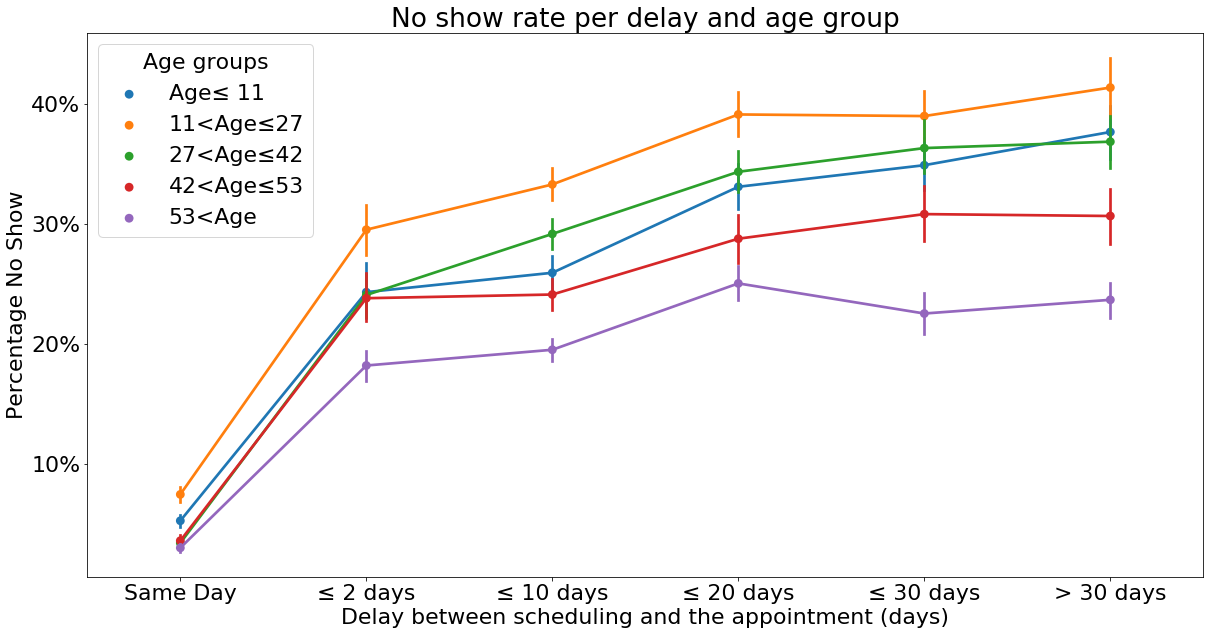

In [40]:
ax = sns.pointplot(x="lag_cat",y="no_show_Yes",hue="age_cat_5_groups", data=data_all_num)
ax.set_title("No show rate per delay and age group");
handles, labels = ax.get_legend_handles_labels();
ax.legend(handles, age_5_groups_labels,title="Age groups");
ax.set_xticklabels(lag_cat_labels);
ax.set_xlabel("Delay between scheduling and the appointment (days)")
ax.set_ylabel("Percentage No Show")
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1,decimals=0))


In [43]:
# We check that each sub-group has indeed enough population to the significantive.
pd.crosstab(data_all_num.appoint_nb_cat,data_all_num.lag_cat)

lag_cat,"(-1.0, 0.1]","(0.1, 2.0]","(2.0, 10.0]","(10.0, 20.0]","(20.0, 30.0]","(30.0, 179.0]"
appoint_nb_cat,,,,,,
"(-1, 5]",33451,10226,21561,12343,9614,9649
"(5, 88]",5027,1633,3660,1073,521,415


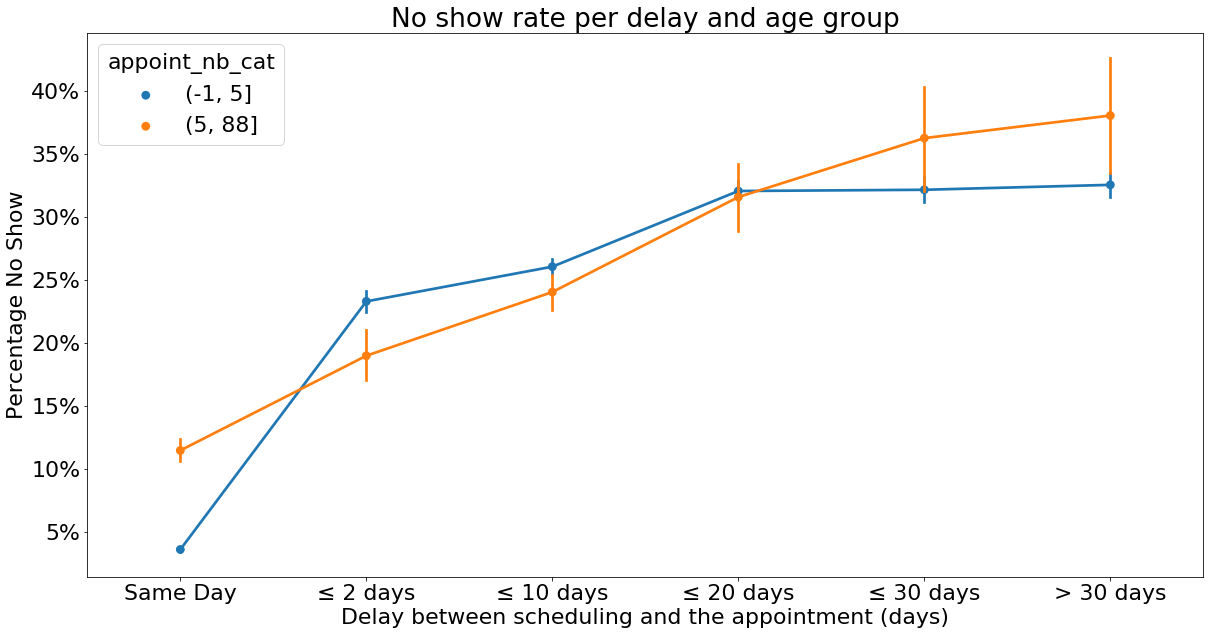

In [44]:
ax = sns.pointplot(x="lag_cat",y="no_show_Yes",hue="appoint_nb_cat", data=data_all_num)
ax.set_title("No show rate per delay and age group");
#handles, labels = ax.get_legend_handles_labels();
#ax.legend(handles, age_3_groups_labels,title="Age groups");
ax.set_xticklabels(lag_cat_labels);
ax.set_xlabel("Delay between scheduling and the appointment (days)")
ax.set_ylabel("Percentage No Show")
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1,decimals=0))


# The influence of sending SMS and the no-show rate
<a id="sms"></a>
Looking at the number of SMS submitted, we notice they are only send if the patient schedule the patient more than 2 days before the appoitment, eventhough the no-show rate is significant (more than 20%) when the appointment is schedule 1 or 2 days before the appointment.

For all delays, we notice an improvements in the no-show rate when the SMS is submitted.

Looking for potential effect of a significant variable, like Age, we notice the Age distribution is not different wether the SMS was submitted or not (we look at the delays greater than 2 days and compare the distribution of Age, the p-value of 23% is very high and the null hypothesis cannot be rejected.)

We can confirm the positive effect of submitting the SMS for all age groups by looking at the no-show rate par age group for appoitment that were schedule more than 2 days in advance (as no SMS is submitted before that).

For the features **Alcoholism**, **Handicap**, the number of people with then is very low.

We can confirm graphically the effect of sending an SMS for the features **Scholarship** and **Hypertension**.

In [45]:
sms_effect = dataset_for_review.groupby(["lag_cat","SMS_received"])["No_show"].value_counts().unstack().fillna(0)

sms_effect["total"] = sms_effect.Yes+sms_effect.No
sms_effect["percent"] = sms_effect.Yes / sms_effect.total
sms_measure = sms_effect.reset_index()
#per_repeat = per_repeat.reset_index()
#plt.bar(per_repeat.index,per_repeat.percent);

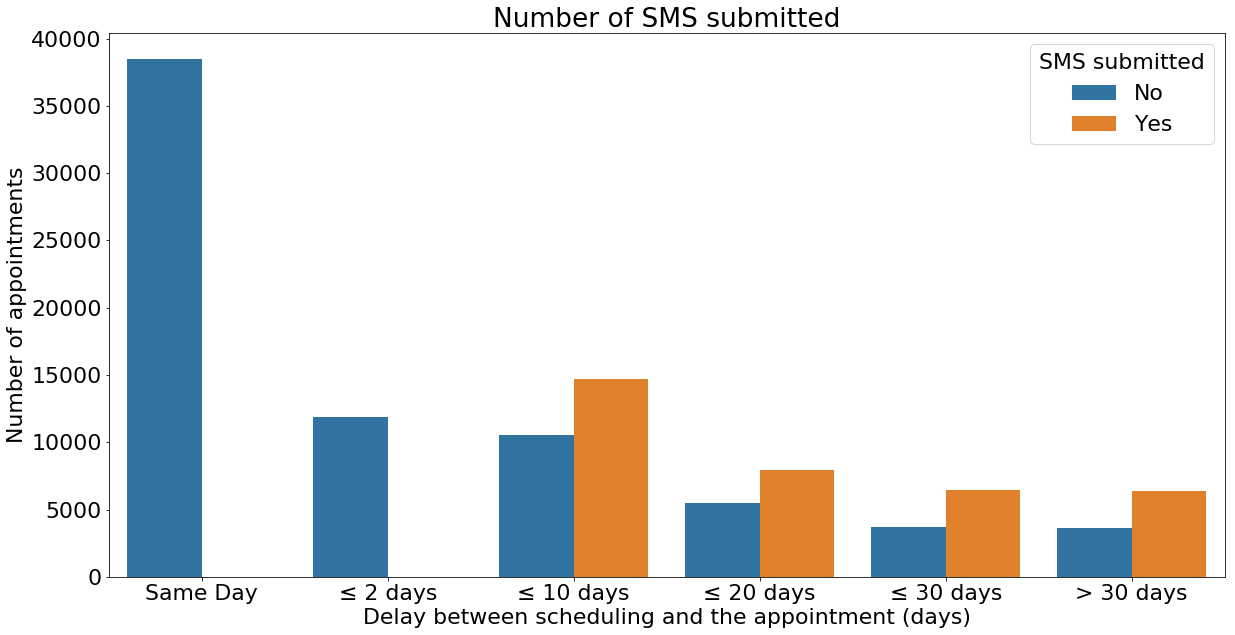

In [46]:
ax = sns.countplot(x="lag_cat", hue="SMS_received", data=data_all_num)
ax.set_title("Number of SMS submitted");
handles, labels = ax.get_legend_handles_labels();
ax.legend(handles, ["No","Yes"],title="SMS submitted",loc='upper right');
ax.set_xticklabels(lag_cat_labels);
ax.set_xlabel("Delay between scheduling and the appointment (days)")
ax.set_ylabel("Number of appointments");


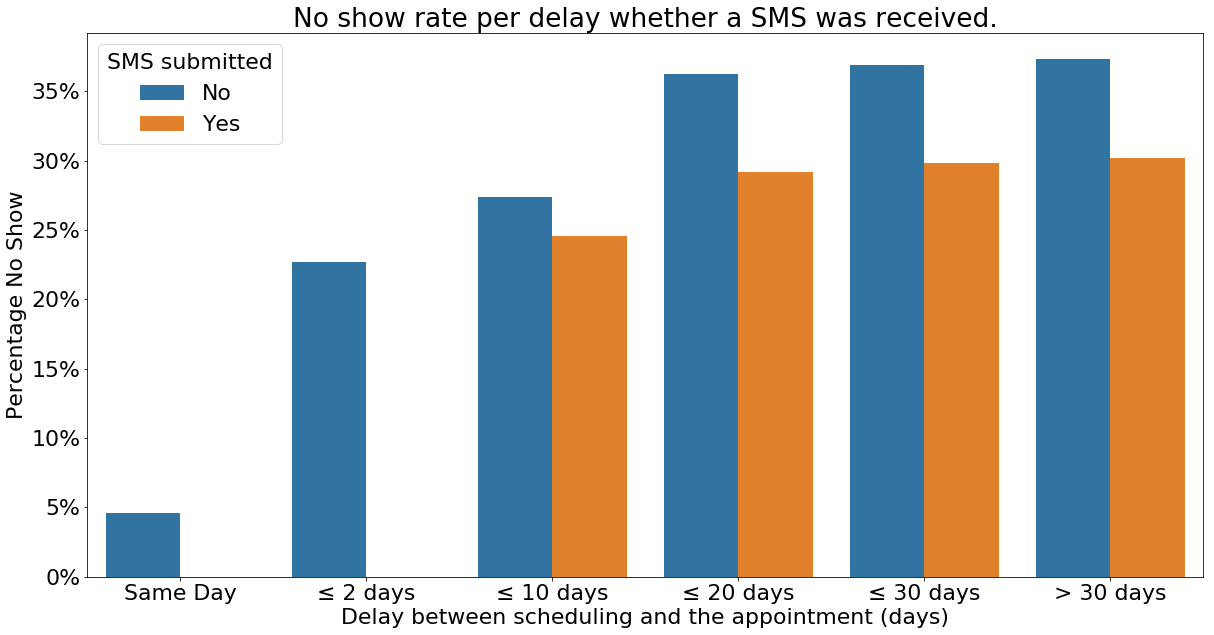

In [47]:
ax = sns.barplot(x="lag_cat", y="percent", hue="SMS_received", data=sms_measure)
ax.set_title("No show rate per delay whether a SMS was received.");
handles, labels = ax.get_legend_handles_labels();
ax.legend(handles, ["No","Yes"],title="SMS submitted",loc='upper left');
ax.set_xticklabels(lag_cat_labels);
ax.set_xlabel("Delay between scheduling and the appointment (days)")
ax.set_ylabel("Percentage No Show")
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1,decimals=0))


We want to check if there is indeed a statisical difference between the No show rate between the population that has received a SMS.

In [48]:
#Create 2 population when delay is more than 2 days, whether they get submitted an SMS or not.
appoint_with_delay_SMS = data_all_num[(data_all_num.delay>2)&(data_all_num.SMS_received==1)]
appoint_with_delay_no_SMS = data_all_num[(data_all_num.delay>2)&(data_all_num.SMS_received==0)]

print(ttest_ind(appoint_with_delay_no_SMS.no_show_Yes,appoint_with_delay_SMS.no_show_Yes,equal_var=False))
print(ttest_ind(appoint_with_delay_no_SMS.no_show_Yes,appoint_with_delay_SMS.no_show_Yes,equal_var=True))

Ttest_indResult(statistic=12.761275526933805, pvalue=3.0985991910727258e-37)
Ttest_indResult(statistic=12.885781527202381, pvalue=6.09238075269069e-38)


As there is a statistical difference, we check if there could be a difference on other features that are significative for the **No show** rate like **Age** for example

In [49]:
print(ttest_ind(appoint_with_delay_no_SMS.Age,appoint_with_delay_SMS.Age,equal_var=False))
print(ttest_ind(appoint_with_delay_SMS.Age,appoint_with_delay_no_SMS.Age,equal_var=True))
print(np.mean(appoint_with_delay_no_SMS.Age),np.mean(appoint_with_delay_SMS.Age))

Ttest_indResult(statistic=1.1962294338599355, pvalue=0.2316129636467542)
Ttest_indResult(statistic=-1.2109911575345076, pvalue=0.22590365800297288)
37.74732379892095 37.513809819063184


# Do we have a different age distribution between the people that receive an SMS or not ?

We clearly have a difference of no-show between the people that received an SMS or not, but is it the influence of another variable, like Age that we saw was an important factor.

With a p-value of 23%, the null hypothesis cannot be rejected, meaning that the distribution are comporable enough they cannot be considered as different.

We will confirm anyway looking at the effect of sending an SMS per age group.

Ttest_indResult(statistic=1.1962294338599355, pvalue=0.2316129636467542)


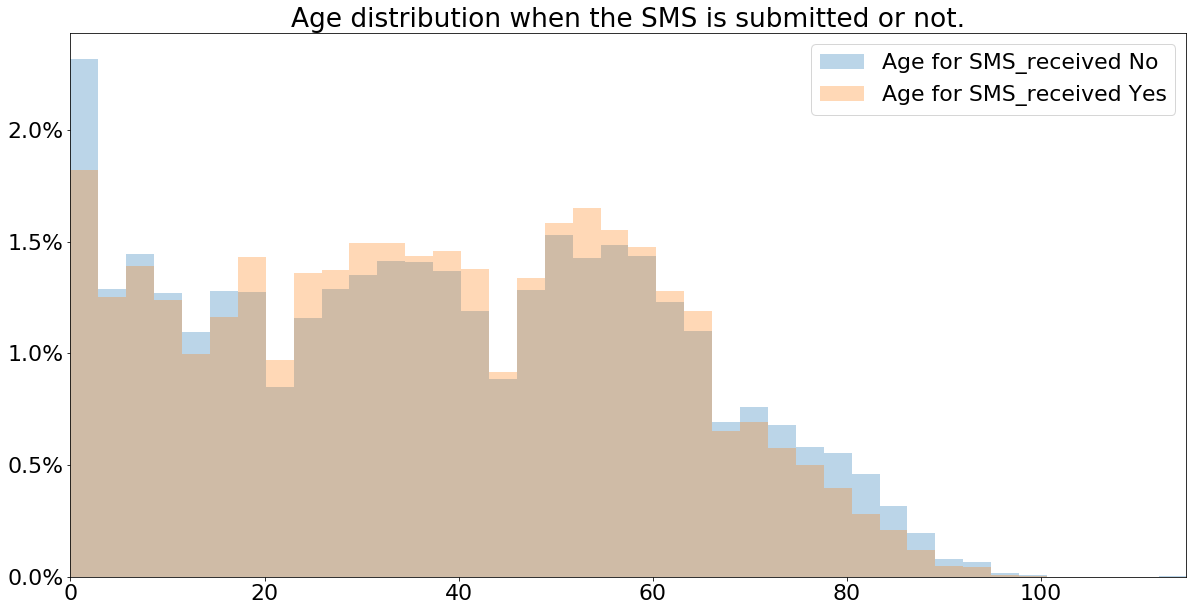

In [52]:
criteria = "SMS_received"
population= "Age"

dist_one = data_all_num[(data_all_num.delay>2) &(data_all_num[criteria]==0)]
dist_two = data_all_num[(data_all_num.delay>2) &(data_all_num[criteria]==1)]

_,bins,_ = plt.hist(dist_one[population],density=True,alpha=0.3,bins=40,label="%s for %s %s"%(population,criteria,"No"));
plt.hist(dist_two[population],density=True,alpha=0.3,bins=bins,label="%s for %s %s"%(population,criteria,"Yes"));
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1,decimals=1))
plt.xlim(0,115)
print(ttest_ind(dist_one[population],dist_two[population],equal_var=False))
plt.title("Age distribution when the SMS is submitted or not.");

# Effect of sending the SMS per Age group

Here we use the more detailed 10 group for the age.

We can see that for all age group, sending an SMS reduces the no-show rate.

We only look at appointment schedule more than 2 days in advance, because in our dataset the SMS are not send otherwise.

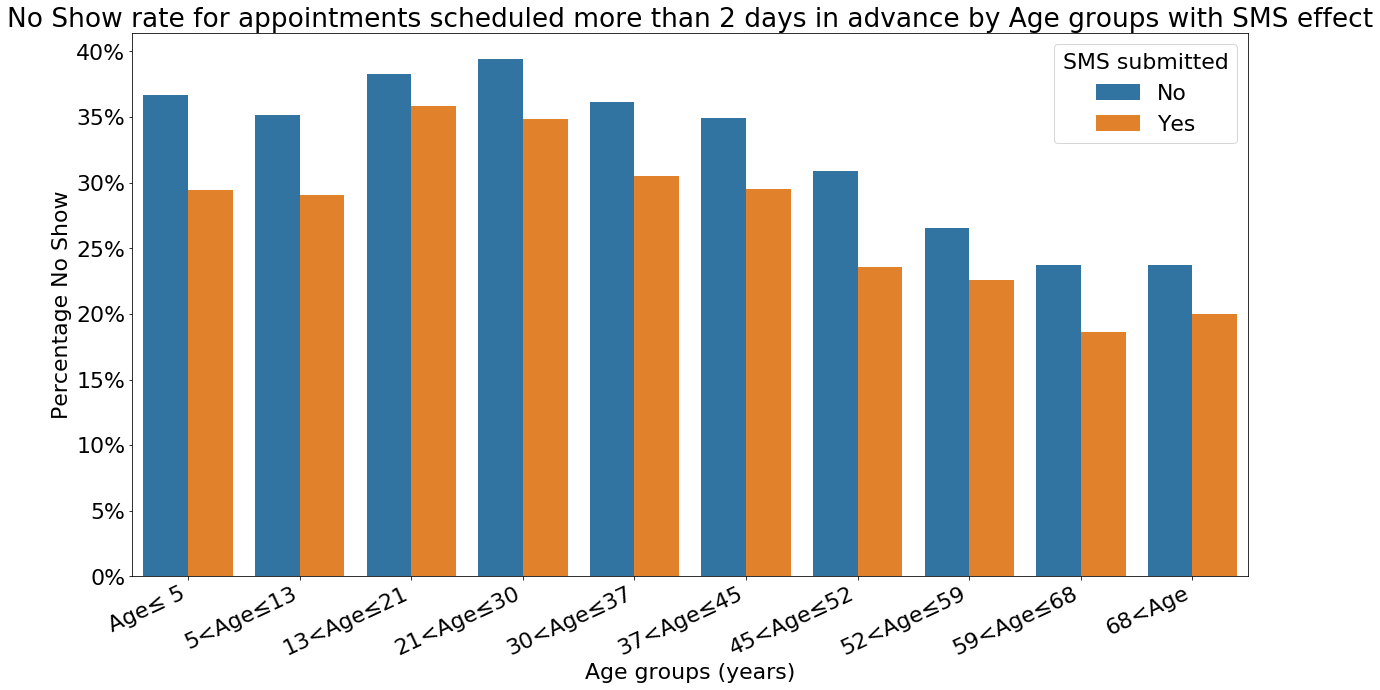

In [53]:
no_show_per_age = data_all_num[data_all_num.delay>2].groupby(["age_cat","SMS_received"])["No_show"].value_counts().unstack().fillna(0)
no_show_per_age["total"] = no_show_per_age.Yes+no_show_per_age.No
no_show_per_age["percent"] = no_show_per_age.Yes / (no_show_per_age.total)
no_show_per_age = no_show_per_age.reset_index()
ax = sns.barplot(x="age_cat", y="percent"
                 , hue="SMS_received"
                 ,data=no_show_per_age)
plt.xticks(rotation=25,verticalalignment="top",horizontalalignment="right");
plt.title("No Show rate for appointments scheduled more than 2 days in advance by Age groups with SMS effect");
handles, labels = ax.get_legend_handles_labels();
ax.legend(handles, ["No","Yes"],title="SMS submitted",loc='upper right');
ax.set_xticklabels(age_cat_labels);
ax.set_xlabel("Age groups (years)")
ax.set_ylabel("Percentage No Show")
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1,decimals=0))

# Looking at other variable than Age

In [54]:
pd.crosstab(data_all_num.Alcoholism,data_all_num.lag_cat)

lag_cat,"(-1.0, 0.1]","(0.1, 2.0]","(2.0, 10.0]","(10.0, 20.0]","(20.0, 30.0]","(30.0, 179.0]"
Alcoholism,,,,,,
0,36940,11532,24475,13075,9922,9899
1,1538,327,746,341,213,165


In [55]:
pd.crosstab(data_all_num.Handicap,data_all_num.lag_cat)

lag_cat,"(-1.0, 0.1]","(0.1, 2.0]","(2.0, 10.0]","(10.0, 20.0]","(20.0, 30.0]","(30.0, 179.0]"
Handicap,,,,,,
0,37548,11553,24743,13192,9990,9935
1,853,284,434,199,129,118
2,71,20,42,21,16,11
3,5,1,2,3,0,0
4,1,1,0,1,0,0


In [56]:
# We check that each sub-group has indeed enough population to the significantive.
pd.crosstab(data_all_num.Scholarship,data_all_num.lag_cat)

lag_cat,"(-1.0, 0.1]","(0.1, 2.0]","(2.0, 10.0]","(10.0, 20.0]","(20.0, 30.0]","(30.0, 179.0]"
Scholarship,,,,,,
0,34296,10955,22714,11961,9137,9385
1,4182,904,2507,1455,998,679


In [57]:
# We check that each sub-group has indeed enough population to the significantive.
pd.crosstab(data_all_num.Hypertension,data_all_num.lag_cat)

lag_cat,"(-1.0, 0.1]","(0.1, 2.0]","(2.0, 10.0]","(10.0, 20.0]","(20.0, 30.0]","(30.0, 179.0]"
Hypertension,,,,,,
0,31727,8657,19489,10899,8390,8462
1,6751,3202,5732,2517,1745,1602


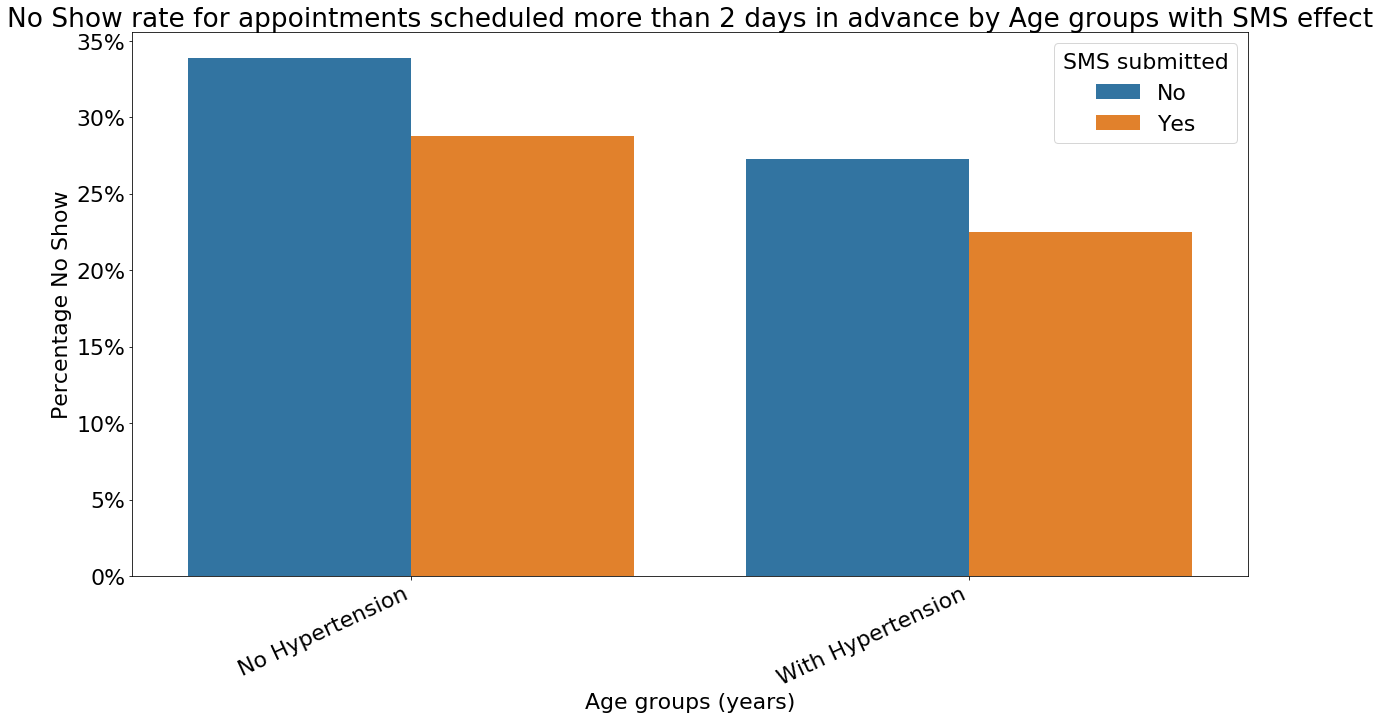

In [58]:
field = "Hypertension"
cats = ["No Hypertension","With Hypertension"]
no_show_per_age = data_all_num[data_all_num.delay>2].groupby([field,"SMS_received"])["No_show"].value_counts().unstack().fillna(0)
no_show_per_age["total"] = no_show_per_age.Yes+no_show_per_age.No
no_show_per_age["percent"] = no_show_per_age.Yes / (no_show_per_age.total)
no_show_per_age = no_show_per_age.reset_index()
ax = sns.barplot(x=field, y="percent"
                 , hue="SMS_received"
                 ,data=no_show_per_age)
plt.xticks(rotation=25,verticalalignment="top",horizontalalignment="right");
plt.title("No Show rate for appointments scheduled more than 2 days in advance by Age groups with SMS effect");
handles, labels = ax.get_legend_handles_labels();
ax.legend(handles,["No","Yes"] ,title="SMS submitted",loc='upper right');
ax.set_xticklabels(cats);
ax.set_xlabel("Age groups (years)")
ax.set_ylabel("Percentage No Show")
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1,decimals=0))

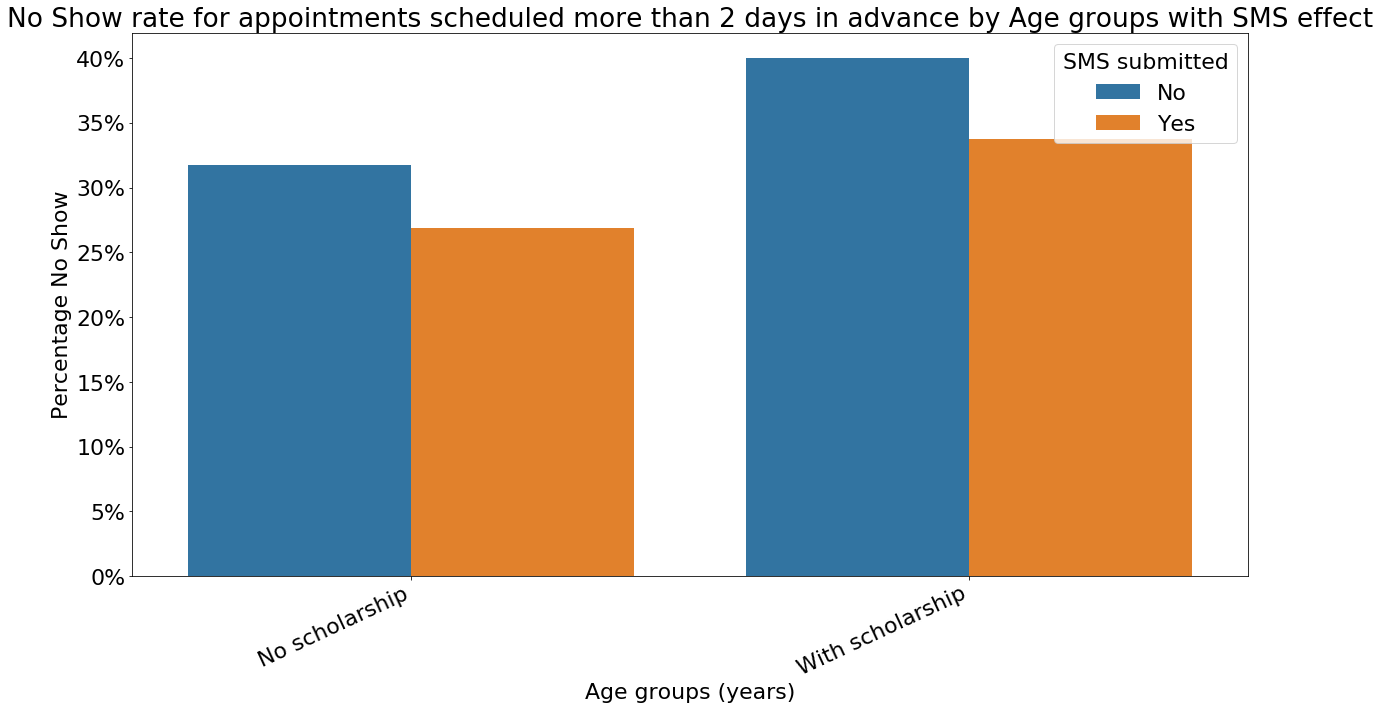

In [59]:
field = "Scholarship"
cats = ["No scholarship","With scholarship"]
no_show_per_age = data_all_num[data_all_num.delay>2].groupby([field,"SMS_received"])["No_show"].value_counts().unstack().fillna(0)
no_show_per_age["total"] = no_show_per_age.Yes+no_show_per_age.No
no_show_per_age["percent"] = no_show_per_age.Yes / (no_show_per_age.total)
no_show_per_age = no_show_per_age.reset_index()
ax = sns.barplot(x=field, y="percent"
                 , hue="SMS_received"
                 ,data=no_show_per_age)
plt.xticks(rotation=25,verticalalignment="top",horizontalalignment="right");
plt.title("No Show rate for appointments scheduled more than 2 days in advance by Age groups with SMS effect");
handles, labels = ax.get_legend_handles_labels();
ax.legend(handles,["No","Yes"] ,title="SMS submitted",loc='upper right');
ax.set_xticklabels(cats);
ax.set_xlabel("Age groups (years)")
ax.set_ylabel("Percentage No Show")
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1,decimals=0))

The assumption is that sending a SMS will help reduce the no-show rate.

To confirm that we will make an experiment by sending a SMS to part of the patient.

The existence of the dataset seems to assume a central booking system exists, we will first work using this assumptions.

We want to roll out the system in a gradual fashion. As the SMS before the patient goes to the appointment, we can send the SMS to some patients and not to others.

We suggest sending out an SMS reminder, gradually :
- Small number number of patient, randomly selected at 10%
- Next step would be at 50%
- Final steap at 100%.

For 10%, we will less than 500 appointment in the test sample per week.

We should get enough sample size in 4 week.

Once the sample size is big enough the test can be confirm.

There does not seem to be reason not to deploy the system fast once the initial test is successful:
- once your system is able to do it for 10%, scaling to 50% should not be a major difference
- SMS is not time consuming for the organisation or the patient
- there should not be any privacy concern raised by sending the SMS




Let's confirm how the test result would look like with actual data.

In [60]:
with_delay = data_all_num.delay > 2
reference_population = data_all_num[with_delay]
ref_neigh = reference_population.Neighbourhood.value_counts()
neighbourhoods = ref_neigh[ref_neigh>300].index


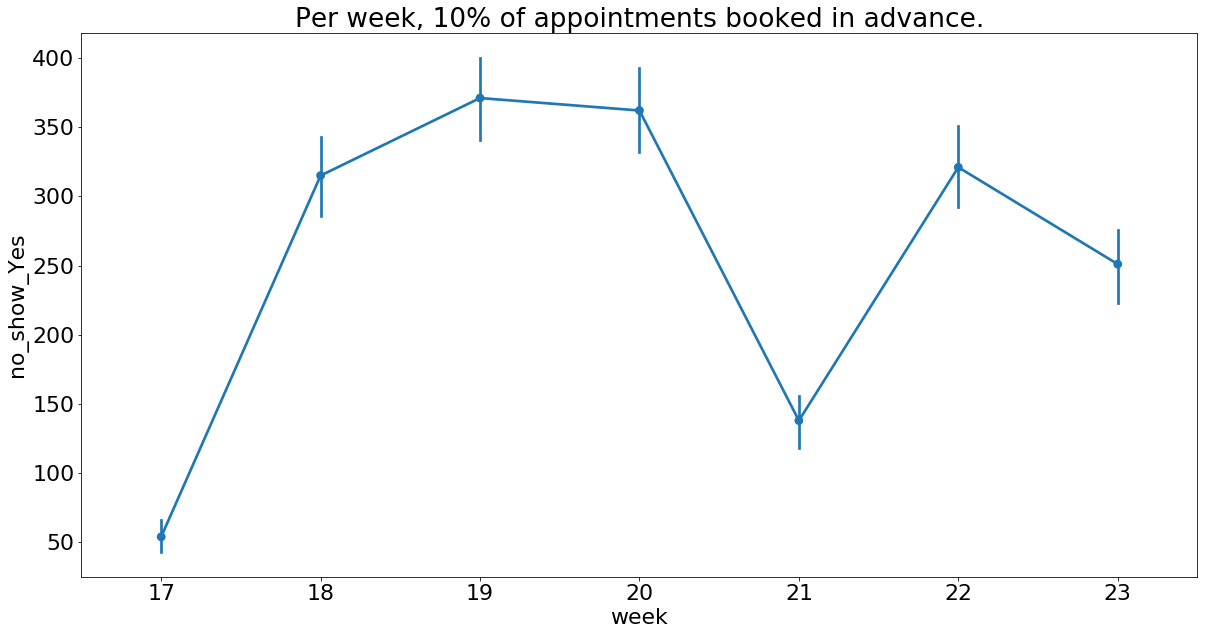

In [61]:
test_population = reference_population.sample(reference_population.shape[0]//10)
ax = sns.pointplot(x="week",y="no_show_Yes", data=test_population,estimator=sum)
ax.set_title("Per week, 10% of appointments booked in advance.");


As the SMS have been send to about half the appointments in the dataset, we can see the results of sending the SMS to 10% of the population by sampling 20% of the appointements (dividing by 5).

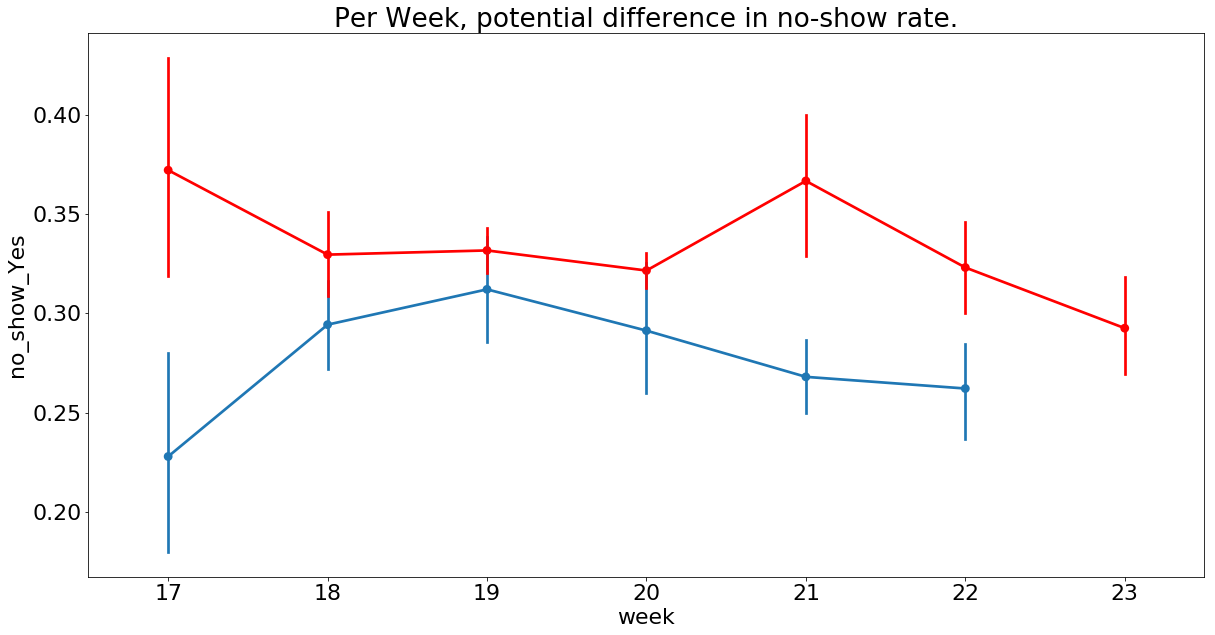

In [62]:
test_population = reference_population.sample(reference_population.shape[0]//5)
ax = sns.pointplot(x="week",y="no_show_Yes", data=test_population[test_population.SMS_received==1],label="No show rate with SMS (test only)")
sns.pointplot(x="week",y="no_show_Yes",color="red", data=reference_population[reference_population.SMS_received==0], label="No show rate without SMS")
ax.set_title("Per Week, potential difference in no-show rate.");


In the case there are constraints that only allow us to send the SMS to all the patient in a particular neighbourhood, we want to select neighbourhood that are representative of all the neighbourhoods.

Create the list of neighbourhood, calculating the p-value with the reference appointment Age distribution (that is the most prevalent parameter), but also **delay**.

We will also check the population is the big enough to justify for the investment of doing the implementation.

To limit the number of calculations, we will limit it to the neighbourhods that have more than 300 appointments.

By selecting a sub-group of 5 neightbourghs, we can then add the p-values and rank according to this sum, with a total population that is larger than 5000 for a period of 7, meaning we will reach a 

By selecting the neighbourhood RESISTÊNCIA, JARDIM DA PENHA, GURIGICA, NOVA PALESTINA, FONTE GRANDE, we get a p_value that is greater than 80% for each feature.

In [63]:
find_list = list()


list_n = data_all_num.Neighbourhood.unique()
for n in combinations(neighbourhoods, 5):
    mine = data_all_num.Neighbourhood.isin(n)
    t_test_delay = ttest_ind(data_all_num[mine&with_delay].delay,reference_population.delay)
    t_test_age = ttest_ind(data_all_num[mine&with_delay].Age,reference_population.Age)
    population = sum(mine&with_delay)
    find_list.append((population,t_test_delay[1],t_test_age[1],n))

KeyboardInterrupt: 

There are 12 Neighbourhood left 

In [71]:
n = ['RESISTÊNCIA',
  'JARDIM DA PENHA',
  'GURIGICA',
  'NOVA PALESTINA',
  'FONTE GRANDE']
mine = data_all_num.Neighbourhood.isin(n)
t_test_delay = ttest_ind(data_all_num[mine&with_delay].delay,reference_population.delay)
t_test_age = ttest_ind(data_all_num[mine&with_delay].Age,reference_population.Age)
population = sum(mine&with_delay)
find_list.append((population,t_test_delay[1],t_test_age[1],n))

In [72]:
results = pd.DataFrame.from_records(find_list,columns=["Nb","Delay_p_value","Age_p_value","Neighbourhood"]).sort_values("Nb",ascending=False)

In [73]:
results["rating"]=results.Age_p_value+results.Delay_p_value

In [74]:
results.sort_values("rating",ascending=False)[:5]

,Nb,Delay_p_value,Age_p_value,Neighbourhood,rating
373862,6837,0.995623,0.969129,"[RESISTÊNCIA, JARDIM DA PENHA, GURIGICA, NOVA ...",1.964752
357813,6550,0.961679,0.985531,"(MARIA ORTIZ, ILHA DO PRÍNCIPE, BELA VISTA, PR...",1.947210
285517,8544,0.997141,0.939161,"(MARIA ORTIZ, CENTRO, CARATOÍRA, SÃO JOSÉ, FOR...",1.936302
286064,8116,0.972734,0.942853,"(MARIA ORTIZ, CENTRO, SÃO PEDRO, ANDORINHAS, G...",1.915587
299775,7265,0.990543,0.917455,"(MARIA ORTIZ, TABUAZEIRO, SÃO PEDRO, BENTO FER...",1.907998


In [75]:
select_n = ['RESISTÊNCIA',
  'JARDIM DA PENHA',
  'GURIGICA',
  'NOVA PALESTINA',
  'FONTE GRANDE']
population = data_all_num[with_delay&(data_all_num.Neighbourhood.isin(select_n))]

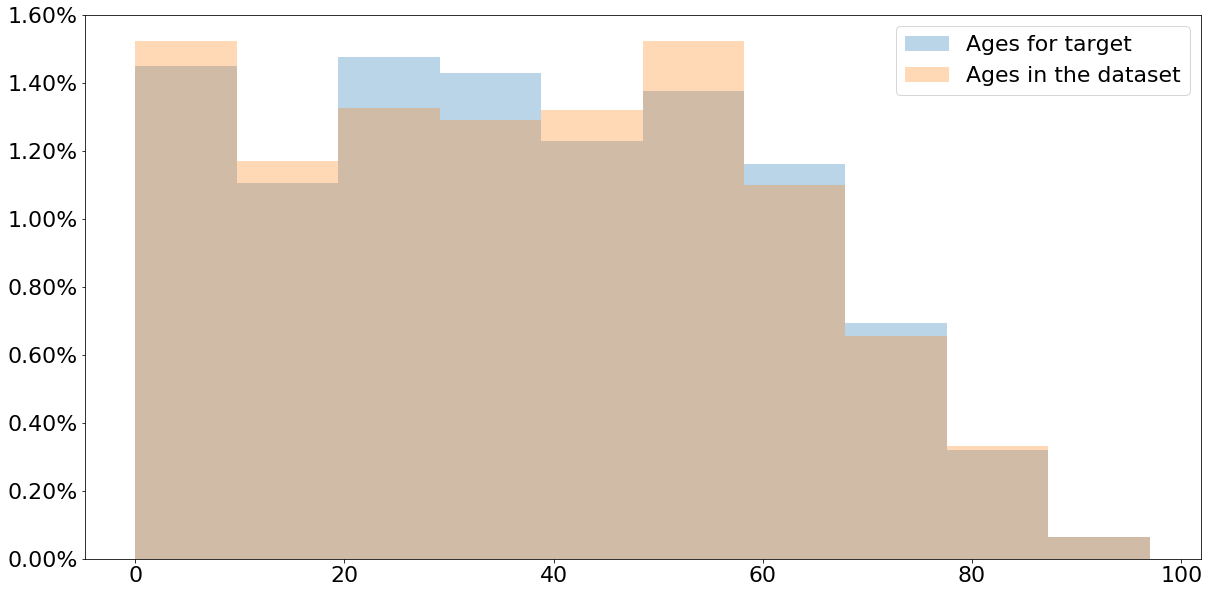

In [76]:
_, bins, _ = plt.hist(population.Age,alpha=0.3,density=True,label="Ages for target")
plt.hist(data_all_num[with_delay].Age,alpha=0.3,density=True,bins=bins,label="Ages in the dataset")
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))


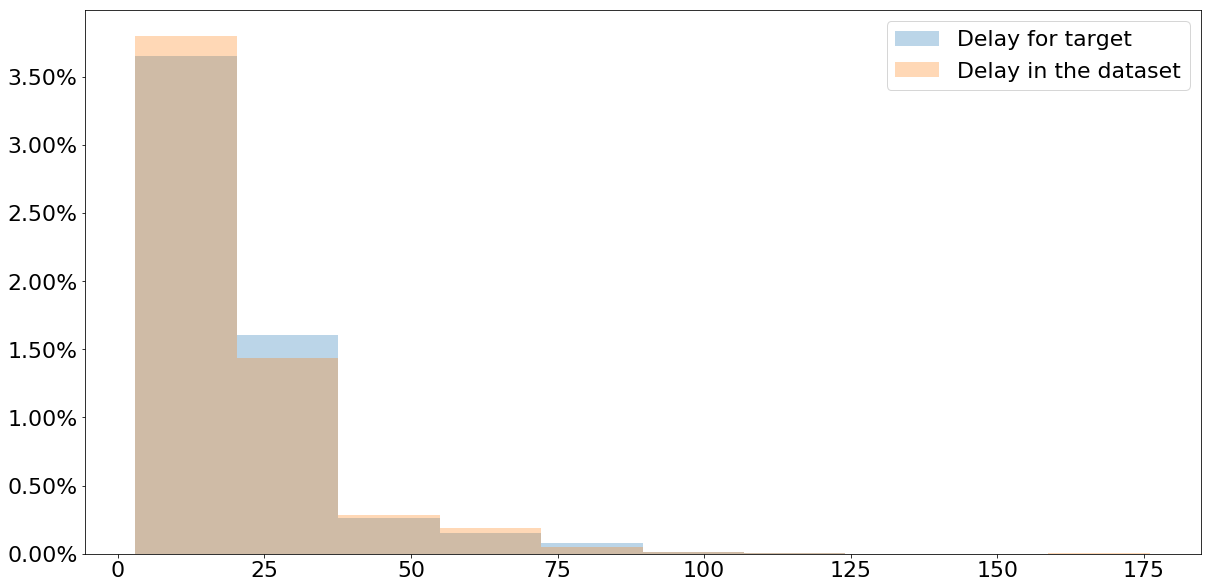

In [77]:
_, bins, _ = plt.hist(population.delay,alpha=0.3,density=True,label="Delay for target")
plt.hist(data_all_num[with_delay].delay,alpha=0.3,bins=bins,density=True,label="Delay in the dataset")
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))


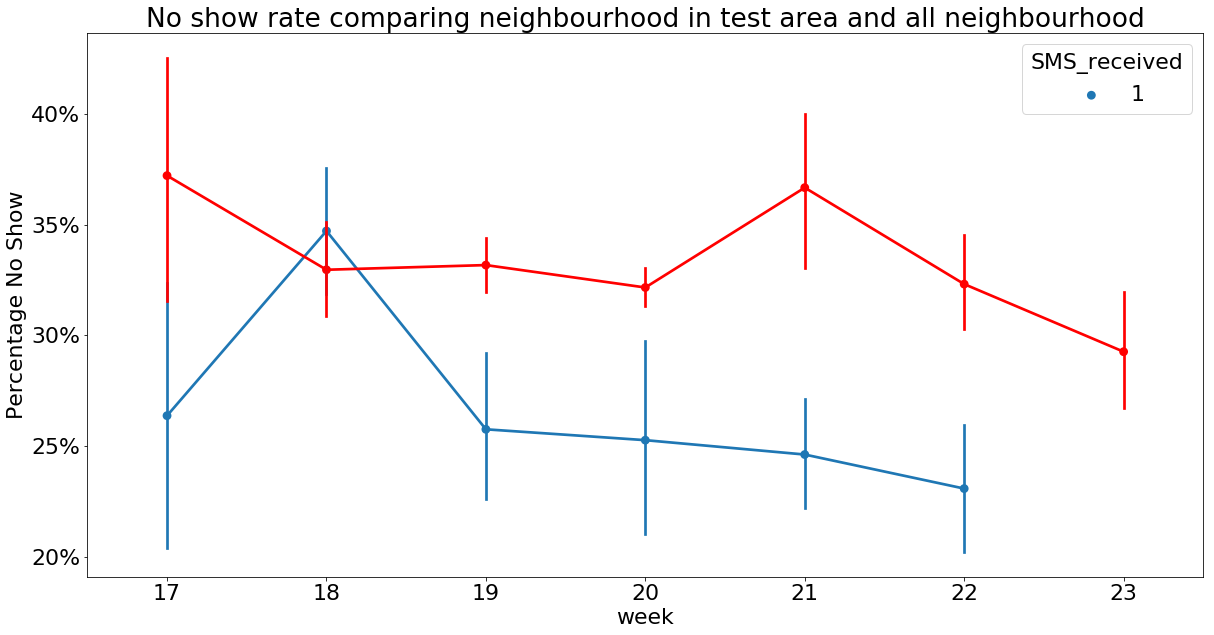

In [78]:
ax = sns.pointplot(x="week", y="no_show_Yes", hue="SMS_received", data=reference_population[reference_population.Neighbourhood.isin(select_n)&reference_population.SMS_received==1])
sns.pointplot(x="week", y="no_show_Yes", color="red", data=reference_population[reference_population.SMS_received==0])
ax.set_title("No show rate comparing neighbourhood in test area and all neighbourhood");
handles, labels = ax.get_legend_handles_labels();
#ax.legend(handles, ["No","Yes"],title="SMS submitted",loc='upper left');
#ax.set_xticklabels(lag_cat_labels);
#ax.set_xlabel("Delay between scheduling and the appointment (days)")
ax.set_ylabel("Percentage No Show")
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1,decimals=0))
